In [1]:
#|hide
#|eval: false
ip = get_ipython()
ip.sphinxify_docstring = True
ip.enable_html_pager = True

![](docs/banner.png)

# Chapter 2: Stochastic Gradient Descent

**By [Tomas Beuzen](https://www.tomasbeuzen.com/) 🚀**

![](img/random.png)

## Chapter Learning Objectives
<hr>

- Explain and implement the stochastic gradient descent algorithm.
- Explain the advantages and disadvantages of stochastic gradient descent as compared to gradient descent.
- Explain what are epochs, batch sizes, iterations, and computations in the context of gradient descent and stochastic gradient descent.

## Imports
<hr>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plotting import *

## 1. Motivation for Stochastic Gradient Descent
<hr>

Last chapter we looked at "vanilla" gradient descent. Almost all loss functions you'll use in ML involve a sum over all the (training) data, e.g., mean squared error:

$$f(w)=\frac{1}{n}\sum^{n}_{i=1}(h_w(x_i)-y_i)^2$$

Here $f(w)$ is the value of the loss function, $h_w(x)$ is the model we wish to fit, e.g., for linear regression: $h_w(x)=w^Tx$. The goal is to find the weights $\boldsymbol{w}$ that minimize the loss function. With gradient descent we:
1. Start with some arbitrary $\boldsymbol{w}$
2. Calculate the gradient using all training examples
3. Use the gradient to adjust $\boldsymbol{w}$
4. Repeat for $I$ iterations or until the step-size is sufficiently small

But if we have large $n$ and/or $\boldsymbol{w}$ vanilla gradient descent becomes very computationally expensive (when we get to deep learning, we'll have models where the number of weights to optimize is in the millions!). Say `n` = 1,000,000, we have 1000 parameters to optimize, and we do 1000 iterations - that's $10^{12}$ computations!

We can reduce this workload by using just a fraction of our dataset to update our parameters each iteration (rather than using the whole data set). This is called "**stochastic gradient descent**".

## 2. Stochastic Gradient Descent
<hr>

Gradient Descent:

$$w_{j+1}=w_{j}-\alpha_t\frac{\partial}{\partial w_j}f(w_j)$$

Stochastic Gradient Descent:

$$w_{j+1}=w_{j}-\alpha_t\frac{\partial}{\partial w_j}f_i(w_j)$$

Pretty simple! What exactly is the difference in the above equations? Well one of them includes a subscript $i$. That means, instead of updating our parameters based on a gradient calculated using all training data, we simply use **one of our data points** (the $i$th one). This is best seen by example, let's use the Pokemon dataset from last chapter:

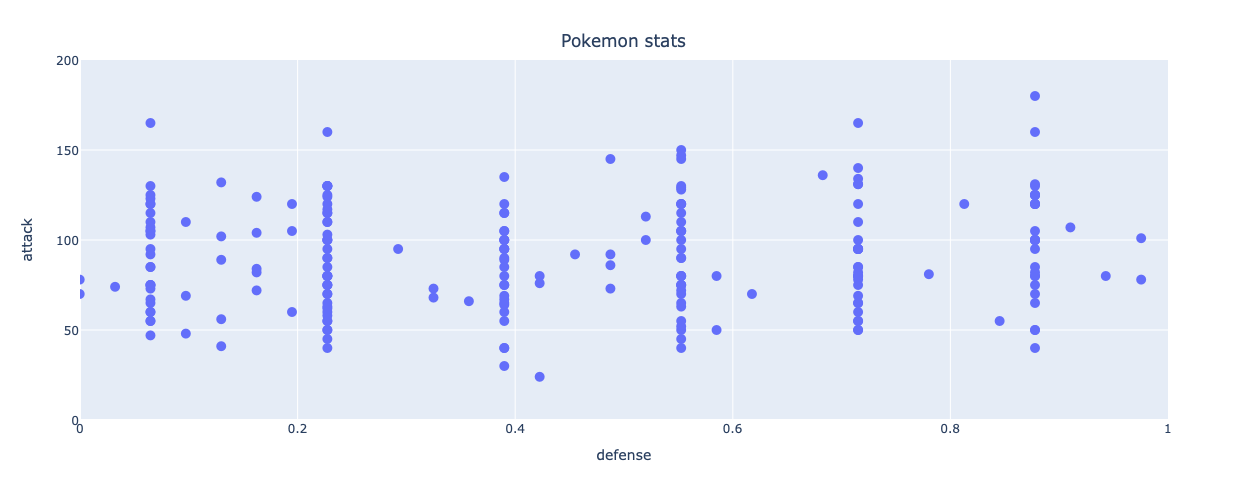

In [3]:
df = (pd.read_csv("data/pokemon.csv", usecols=['name', 'defense', 'attack'], index_col=0)
        .reset_index()
     )
x = StandardScaler().fit_transform(df[['defense']]).flatten()
y = df['attack'].to_numpy()
plot_pokemon(x, y, x_range=[0, 1], y_range=[0, 200], dx=0.2, dy=50)

Let's fit a simple linear model to this data: $\hat{y_i}=w_0+w_1x_i=w^Tx_i$. Recall from last chapter that the gradient of the MSE loss for this linear regression model is:

$$\frac{\partial{}}{\partial{}f(w)}=\frac{2}{n}\sum^{n}_{i=1}(w^Tx_i-y_i)x_i$$

In [4]:
def gradient(w, X, y):
    """Gradient of mean squared error."""
    return 2 * (X.T @ (X @ w) - X.T @ y) / len(X)

Let's use the "column of ones trick" to add a column of ones to our feature data to represent the intercept term:

In [5]:
X = np.hstack((np.ones((len(x), 1)), x[:, None]))
X

array([[ 1.        , -0.78077335],
       [ 1.        , -0.32548801],
       [ 1.        ,  1.62573488],
       ...,
       [ 1.        , -0.65069183],
       [ 1.        ,  0.91028648],
       [ 1.        ,  1.36557183]])

Let's calculate the gradient for parameters `(w0, w1)` = `(-20, -5)` using the full data set:

In [6]:
w = np.array([-20, -5])
gradient(w, X, y)

array([-195.71535581,  -40.14066881])

Now, let's calculate the gradient again using just a single random point (re-run this as many times as you like):

In [7]:
i = np.random.randint(0, len(X), 1)
print("Selected point:")
display(df.iloc[i])
print("      Gradient: [intercept, slope]")
print(f"      All data: {[round(_, 2) for _ in gradient(w, X, y)]}")
print(f"Data point {i[0]:03}: {[round(_, 2) for _ in gradient(w, X[i], y[i])]}")

Selected point:


name  attack  defense
177  Xatu      75       70

      Gradient: [intercept, slope]
      All data: [-195.72, -40.14]
Data point 177: [-189.02, 18.49]


Not surprisingly, the gradient calculated using just one data point is different to the gradient calculated using all data points. For visualization purposes, let's assume the intercept is fixed and just look at the gradient of the slope parameter ($w_1$) at $w_1=-5$ at different indiviudal data points:

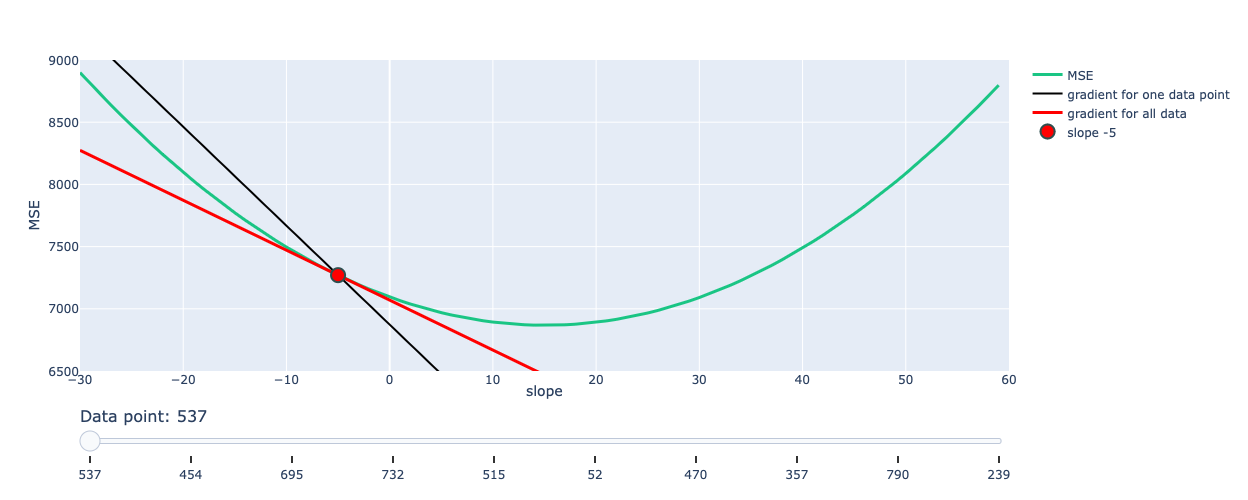

In [8]:
plot_random_gradients(x, y, w=w[1], seed=2023)  # re-run to get different datapoints

Notice here that at a slope of -5, our single data point gradients vary in direction and magnitude. Let's plot a histogram of the gradient of each data point at a slope of -5:

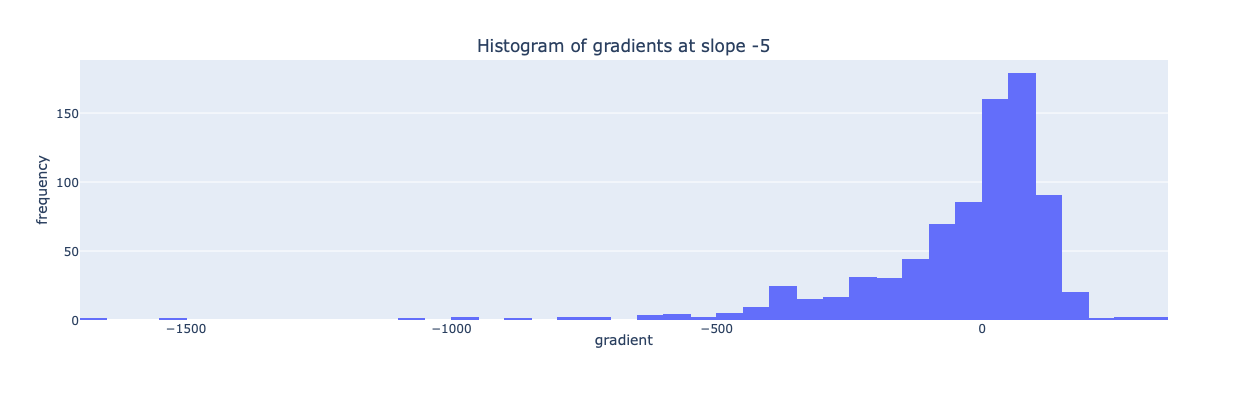

In [9]:
plot_gradient_histogram(x, y, w=w[1])

The histogram is left-skewed, indicating that more often that not, our gradient is negative (i.e., we need to increase our slope to decrease our loss - if you look at the plot above this one, you'll see that makes sense). This means that we're **highly likely to move towards the minimum even if we only use a single data point!**. Hopefully you're semi-convinced that using just one data point is computational way faster, and mathematically not a totally horrible idea.

Let's see stochastic gradient descent in action in the 2d case. It's pretty much the same as we saw last chapter, except that we pick a random data point at which to calculate the gradient (which is why we call it "stochastic").

>For those who notice it, I've also removed the "tolerance" termination criteria in our stochastic gradient descent implementation below. The reason for this is that to fairly calculate the step size which we compare to our tolerance, we should use the whole data set, as we do in regular gradient descent, not just a fraction of it. But if we do this each iteration, we forfeit the computational savings of stochastic gradient descent! So we typically leave that stopping criteria out.

In [10]:
def stochastic_gradient_descent(x, y, w, alpha, num_iterations=300, print_progress=100, seed=None):
    """Stochastic gradient descent for simple linear regression."""
    
    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1        # init iterations
    if seed is not None:  # init seed (if given)
        np.random.seed(seed)
        
    while iterations <= num_iterations:
        i = np.random.randint(len(x))            # <--- this is the only new bit! <---
        g = gradient(w, x[i, None], y[i, None])  # calculate current gradient
        w -= alpha * g                           # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:     # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1  # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

In [11]:
w = [-20, -5]
alpha = 0.01
X = np.hstack((np.ones((len(x), 1)), x[:, None]))

In [12]:
%time 
stochastic_gradient_descent(X, y, w, alpha, seed=2020)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 69.19. Slope 21.12.
Iteration 200. Intercept 76.37. Slope 18.07.
Iteration 300. Intercept 78.32. Slope 17.21.
Terminated!
Iteration 300. Intercept 78.32. Slope 17.21.


The correct values (according to sklearn) are:

In [13]:
%time
m = LinearRegression().fit(np.atleast_2d(x).T, y)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [14]:
print(f"sklearn Intercept = {m.intercept_:.2f}")
print(f"sklearn Slope = {m.coef_[0]:.2f}")

sklearn Intercept = 77.86
sklearn Slope = 15.07


We got pretty close! Let's see the path we took:

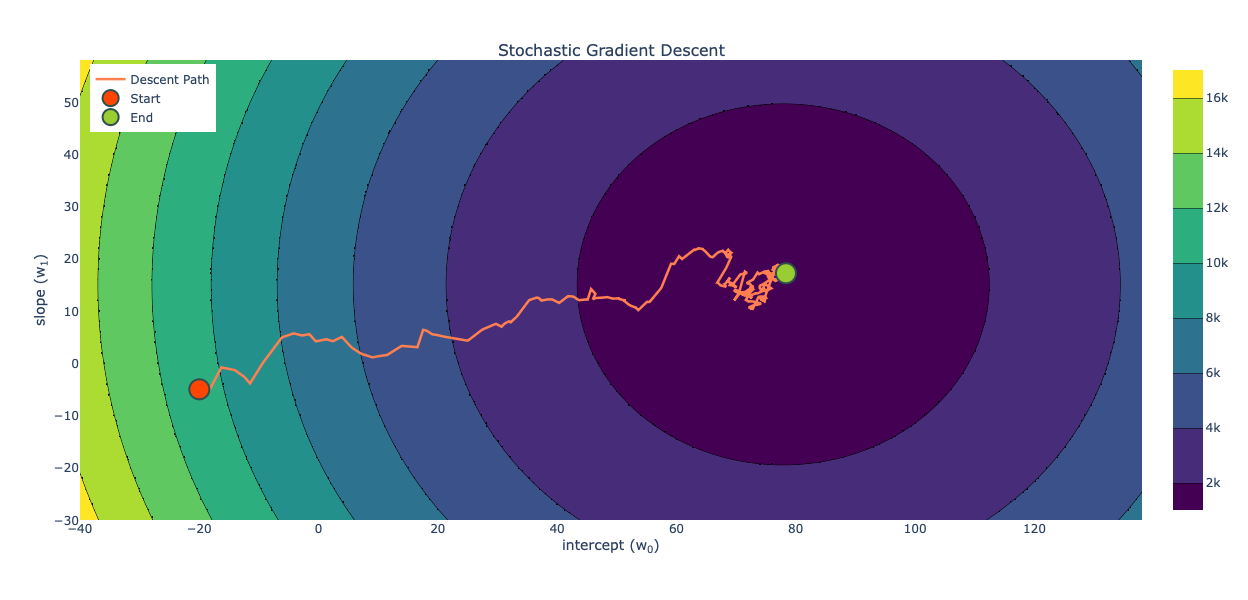

In [15]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, seed=2020)

Above, we get to the minimum fairly quickly and then bounce around. The "noisiness" in our approach to the minimum is because we are only basing our steps on one data point. Remember, each data point has it's own idea of how the model's parameters should change. But as we saw earlier, it turns out that most of them want us to move us in the direction of the minimum!

Let's compare the above result to regular gradient descent:

In [16]:
def gradient_descent(x, y, w, alpha, ϵ=2e-4, max_iterations=5000, print_progress=100):
    """Gradient descent for optimizing simple linear regression."""
    
    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1  # init iterations
    dw = np.array(2 * ϵ)      # init. dw
    
    while abs(dw.sum()) > ϵ and iterations <= max_iterations:
        g = gradient(w, x, y)  # calculate current gradient
        dw = alpha * g         # change in w
        w -= dw                # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:  # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1        # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

In [17]:
%time
gradient_descent(X, y, w, alpha)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 2.86 µs
Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 64.88. Slope 12.41.
Iteration 200. Intercept 76.14. Slope 14.72.
Iteration 300. Intercept 77.63. Slope 15.02.
Iteration 400. Intercept 77.83. Slope 15.06.
Terminated!
Iteration 466. Intercept 77.85. Slope 15.07.


This got us the *exact* same answer as sklearn, let's take a look at the path:

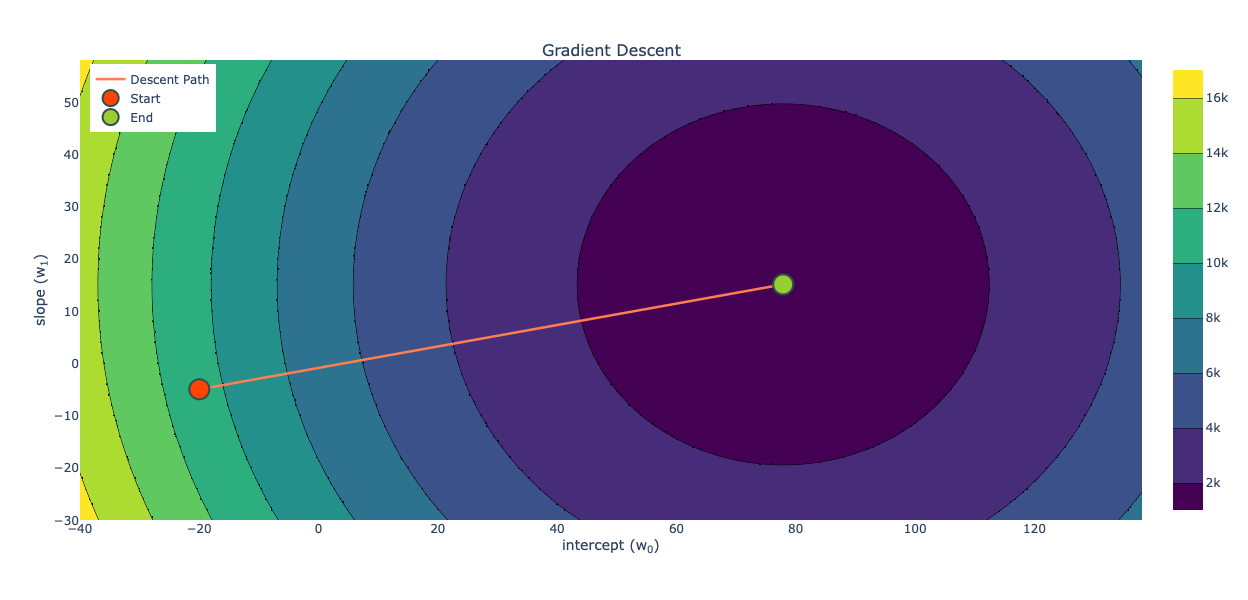

In [18]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2))

Obviously vanilla gradient descent looks nice above, but consider the computational savings:
- In stochastic gradient descent we converged after 300 "iterations": 1 iteration = 1 data point, **so we did 300 computations** (although I'll note that I told the algorithm to do 300 iterations, we could have specified less or more, it won't change the fact that we saved a lot of computational time here!)
- In gradient descent we converged after 466 "iterations": 1 iteration = 801 data points, **so we did 466 x 801 = 373,266 computations**

## 3. Mini-batch Gradient Descent
<hr>

Okay so it appears stochastic gradient descent is computationally better than gradient descent, but gradient descent makes better steps ("iterations"). Is there an in-between compromise? Yes!

Enter: minibatch stochastic gradient descent. The idea here is simple, rather than calculating the gradient from just one random point, calculate it based on a "batch" of points:

In [19]:
batch_size = 5
i = np.random.choice(range(len(X)), batch_size)
print("Selected point:")
display(df.iloc[i])
print("   Gradient of: [intercept, slope]")
print(f"      All data: {[round(_, 2) for _ in gradient(w, X, y)]}")
print(f"Data point {i[0]:03}: {[round(_, 2) for _ in gradient(w, X[i], y[i])]}")

Selected point:


name  attack  defense
65       Machop      80       50
278    Pelipper      50      100
4    Charmeleon      64       58
19     Raticate      71       70
605    Beheeyem      75       75

   Gradient of: [intercept, slope]
      All data: [-195.72, -40.14]
Data point 065: [-175.22, 19.69]


We would still expect the gradient calculated from a batch of data to be different to the gradient calculated using all the data, but not as different to using only a single point. Once again let's visualize this for just the slope parameter to drive the point home:

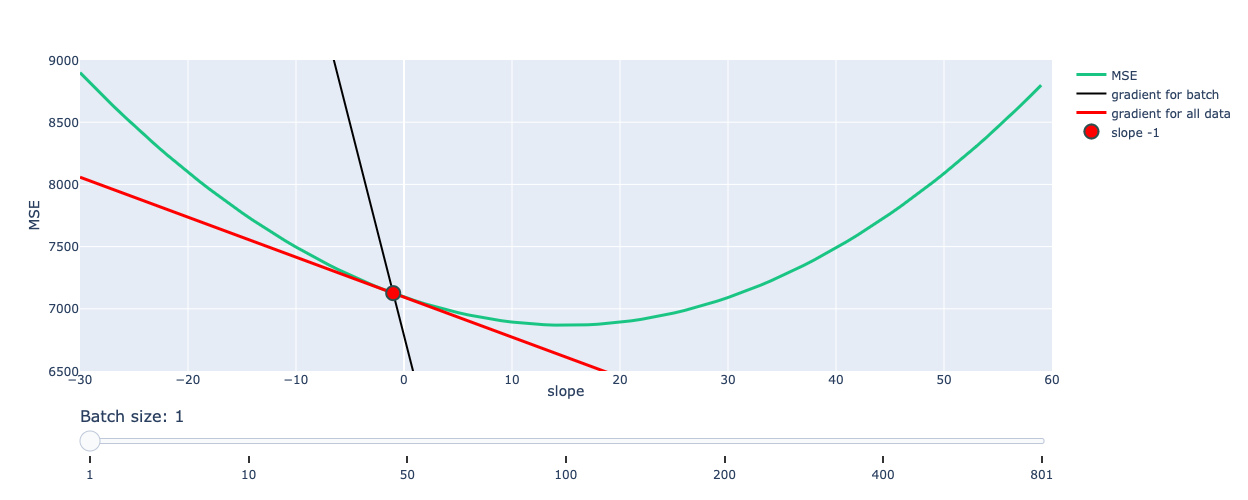

In [20]:
plot_minibatch_gradients(x, y, w=-1, batch_sizes=[1, 10, 50, 100, 200, 400, len(x)], seed=2023)

Above we can see that the larger the batch of data we use, the closer we are to the gradient calculated using the whole dataset (which makes sense). But also the bigger the batch, the more computations will be needed!

Let's code up minibatch gradient descent. The code is almost the same as before but we are choosing `batch_size` of random points each iteration. 

> We'll be sampling without replacement in each iteration, I'll talk about that more later.

In [23]:
def minibatch_gradient_descent(x, y, w, alpha, batch_size, num_iterations=300, print_progress=100, seed=None):
    """Minibatch gradient descent for simple linear regression."""
    
    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1        # init iterations
    if seed is not None:  # init seed (if given)
        np.random.seed(seed)
        
    while iterations <= num_iterations:
        i = np.random.choice(range(len(x)), batch_size, replace=False)  # <--- this is the only new bit! <---
        g = gradient(w, x[i], y[i])              # calculate current gradient
        w -= alpha * g                           # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:     # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1  # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

In [24]:
batch_size = 10
minibatch_gradient_descent(X, y, w, alpha, batch_size=batch_size, seed=2020)

Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 65.25. Slope 11.61.
Iteration 200. Intercept 75.84. Slope 12.49.
Iteration 300. Intercept 77.67. Slope 14.42.
Terminated!
Iteration 300. Intercept 77.67. Slope 14.42.


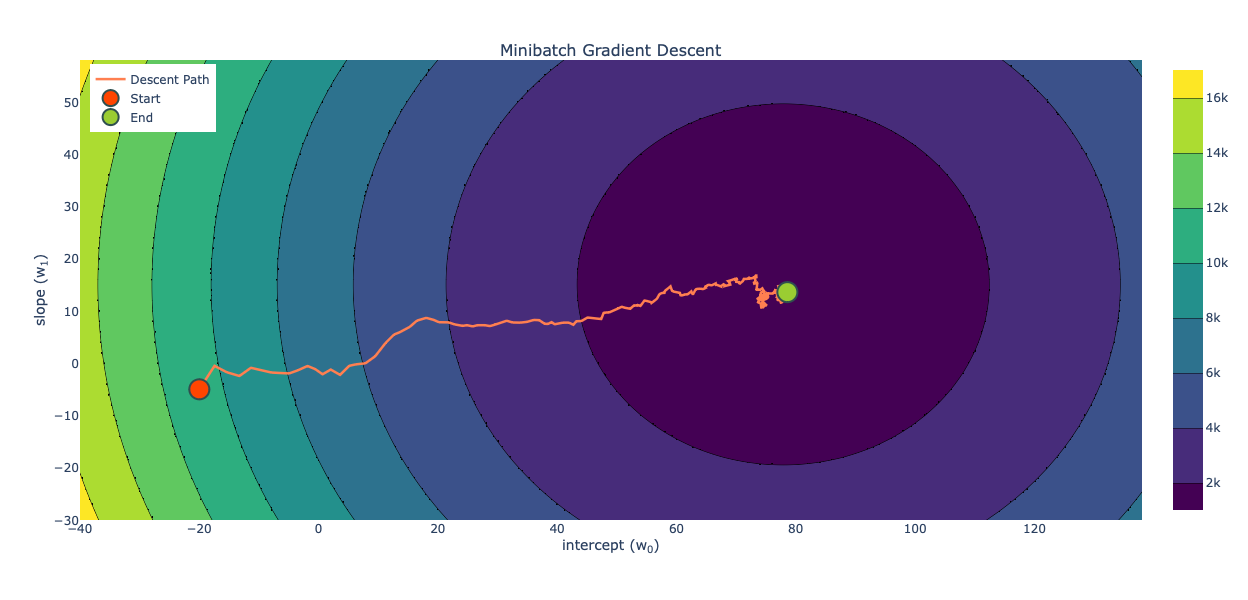

In [21]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, batch_size=batch_size, seed=2020)

Above, we still get the "wobbliness" of stochastic gradient descent but it's much smoother now!

Let's view our three algorithms all together now!

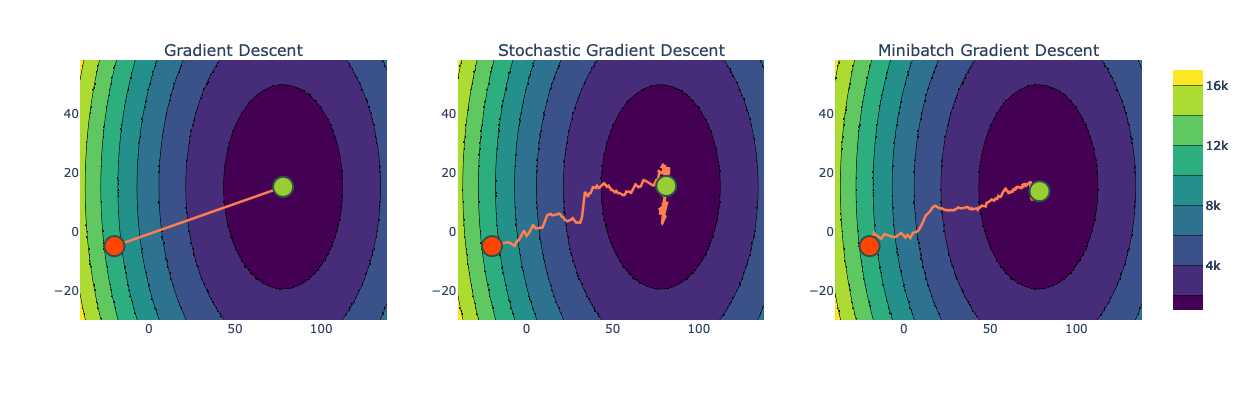

In [22]:
f1 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2))
f2 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, seed=2023)
f3 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-30, 60, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, batch_size=batch_size, seed=2020)
plot_panel(f1, f2, f3)

|Method|Intercept|Slope|Iterations|Data Per Iteration|Data Points Used|
|---|---|---|---|---|---|
|sklearn|77.86|15.07|-|-|-|
|gradient descent|77.85|15.07|466|801|373,266|
|stochastic gradient descent|76.33|11.26|300|1|300|
|Mgradient descent|75.60|15.09|300|10|3000|

## 4. Terminology
<hr>

So I've used a couple of important terms in the last two chapters and it's time we clarify them. Assume we have a dataset of $n$ observations. There are three terms you need to know when it comes to gradient descent algorithms:
- **Iteration**: each time you update model weights
- **Batch**: a subset of data used in an iteration
- **Epoch**: the number of iterations to look at all $n$ observations (people sometimes also say a "full pass through the dataset")

Let's put those defintions in context:
- In gradient descent, each iteration involves computing the gradient over all examples, so $1 \text{ iteration} = 1 \text{ epoch}$
- In stochastic gradient descent, each iteration involves one data point, so $n \text{ iterations} = 1 \text{ epoch}$
- In minibatch gradient descent, each iteration involves a batch of data, so $\frac{n}{\text{batch size}} \text{ iterations} = 1 \text{ epoch}$

From our examples above (recall that $n=801$):

|Method|Iterations|Data Per Iteration (batch size)|Epochs|
|---|---|---|---|
|gradient descent|466|801|466|
|stochastic gradient descent|300|1|0.37|
|Mgradient descent|300|10|3.74|

In practice nobody really says "minibatch stochastic gradient descent", we just say stochastic gradient descent and in stochastic gradient descent you can specify a batch size of anything between 1 and $n$. So, why do we bother with all this hassle? Because we want a quantity to talk about that is meaningful to humans:
- "I did 10 iterations of gradient descent" means something (that's 10 full passes through the dataset).
- "I did 10 iterations of stochastic gradient descent" means nothing to me (it depends what the batch size is).
- "I did 10 epochs of stochastic gradient descent" has more meaning to me (that's 10 full passes through the dataset). 

## 5. Final Remarks
<hr>

### 5.1. Sampling With or Without Replacement

When doing stochastic gradient descent we really have 3 options:
1. Shuffle the dataset and pre-divide it into batches, like cross-validation. This is "without replacement", every example is used once.
2. Sample a batch each iteration without replacement, so you won't have the same sample occuring more that once in a batch but you might have the same example in both batch 1 and batch 2. Every example may not be used in this approach.
3. Like Approach 2, but even each batch is sampled with replacement, so you might have the same example twice in batch 1. Every example may not be used in this approach.

We typically use approach 1 or 2 (the default in Pytorch, the deep learning package we'll be using, is approach 1). Empirically, sampling without replacement tends to lead to more optimal solutions/faster convergence and this has been [proved mathematically in some cases](https://arxiv.org/pdf/1202.4184v1.pdf).

### 5.2. Learning Rate

Up until now we've been using a constant learning rate ($\alpha$) in our algorithms. There are two main ways we could potentially improve on this naive method:
1. Use an "adaptive" learning rate - where we take big steps when we are far from the minimum of our loss function, and smaller steps when we are close to it;
2. Use "momentum" - using how our learning rate has changed in past iterations to influence how it changes in future iterations

Often when people use stochastic gradient descent they leave $\alpha$ constant and things tend to work out okay. However these days in practice we often use fancier variants of gradient descent, such as Adam, which include more bells and whistles such as those I describe above. We'll be using Adam a lot through the rest of this course. These algorithms get pretty complex and it's beyond the scope of the course to know exactly how to derive them, but just know they are essentially fancier versions of gradient descent (if you're interested in reading more about these kinds of algorithms, see [here](https://ruder.io/optimizing-gradient-descent/)).

### 5.3. Local Minima

Optimization algorithms like gradient descent are susceptible to getting stuck in local minima. That means, minima that are not the true global minima, but are still a "dip" in the loss function. Stochastic gradient descent can help with this a bit due to the "jumpy" randomness in the optimization process, but note that the main advantage of stochastic gradient descent vs gradient descent is really the computational savings.

The above mentioned fancy algorithms like Adam that include things like momentum and adaptive learning rates are better designed to speed up convergence and try and avoid local minima. Here's a comparison of stochastic gradient descent vs Adam for an arbitrary loss function and model - notice how stochastic gradient descent gets "stuck" in a local minima, while Adam is able to navigate all the way to the global minima:

![](img/adam.png)